<a href="https://colab.research.google.com/github/rizalagussaini/diabetes_prediction_xgboost/blob/main/Prediksi_Diabetes_XG_Bosst.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 1. Import Library
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE
import xgboost as xgb


In [ ]:
# Load dataset
dataset = pd.read_csv("diabetes.csv")

# Cek 5 data pertama
dataset.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [ ]:
# Mengecek jumlah nilai 0 pada setiap kolom
zero_counts = (dataset == 0).sum()
print(zero_counts)

Pregnancies                 111
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                     500
dtype: int64


In [ ]:
# 3. Cleaning - Ganti nilai 0 yang tidak masuk akal
cols_with_zero = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
for col in cols_with_zero:
    dataset[col] = dataset[col].replace(0, np.nan)
    dataset[col] = dataset[col].fillna(dataset[col].median())

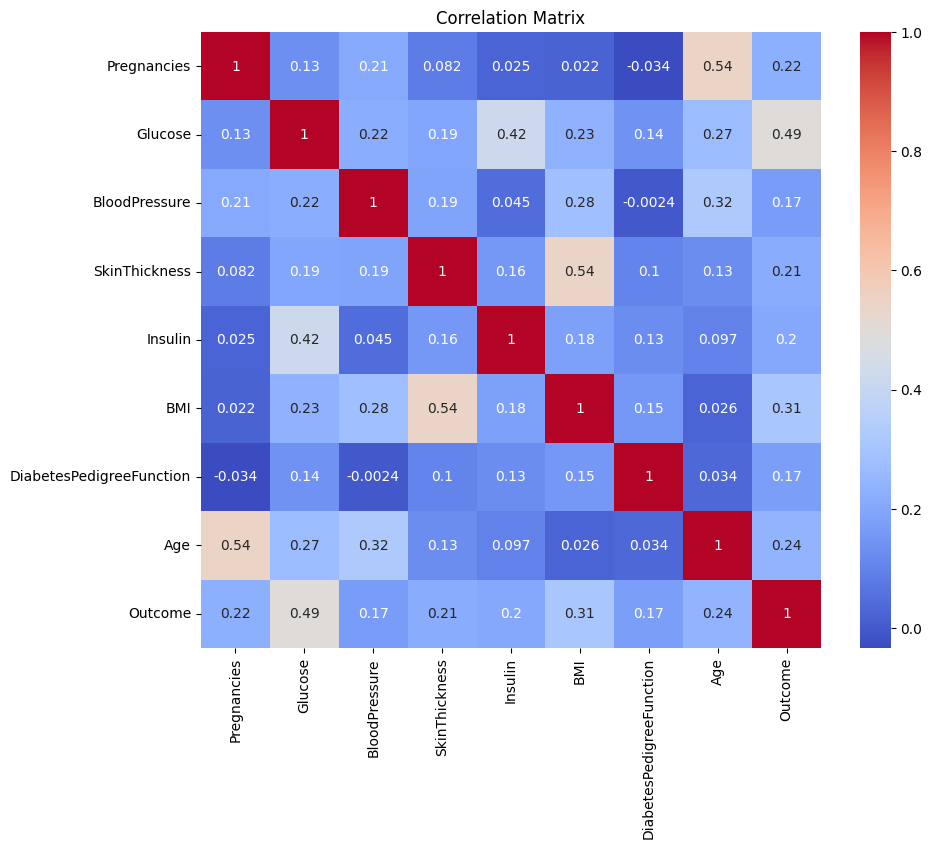

In [ ]:
# 4. Correlation Matrix
plt.figure(figsize=(10,8))
sns.heatmap(dataset.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [ ]:
# 5. Pisahkan fitur dan target
X = dataset.drop('Outcome', axis=1)
y = dataset['Outcome']


In [ ]:
# 6. Feature Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
# 8. Train Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

In [ ]:
# 7. SMOTE Balancing (karena data tidak seimbang)
sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X_train, y_train)

In [ ]:

# 9. Tuning Hyperparameter XGBoost
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5, 6],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.3],
    'reg_alpha': [0, 0.01, 0.1],
    'reg_lambda': [1, 1.5, 2],
    'scale_pos_weight': [1, 1.5, 2]
}

xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    random_state=42
)

random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_grid,
    n_iter=30,
    scoring='recall',  # Fokus ke recall
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train, y_train)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='logloss',
                                           feature_types=None, gamma=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning...
                                           num_parallel_tree=None,
                                           random_state=42, ...),
                   n_iter=30, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                                        'gamma': [0, 0.1, 0.3],
                                        'learning_rate': [0.01, 0.05, 0.1],
                                        'max_depth': [3, 4, 5, 6],
                                        'n_estimators': [100, 200, 300],
                                        'reg_alpha': [0, 0.01, 0.1],
                                        'reg_lambda': [1, 1.5, 2],
                                        'scale_pos_weight': [1, 1.5, 2],
                                        'subsample': [0.6, 0.8, 1.0]},
                   random_state=42, scoring='recall', verbose=1)

In [ ]:
# 10. Hasil Tuning
print("Best Parameters:", random_search.best_params_)

Best Parameters: {'subsample': 0.6, 'scale_pos_weight': 2, 'reg_lambda': 2, 'reg_alpha': 0.1, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.01, 'gamma': 0.3, 'colsample_bytree': 0.6}


In [ ]:
# 11. Evaluasi Model
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_proba))


Confusion Matrix:
[[70 30]
 [ 9 45]]

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.70      0.78       100
           1       0.60      0.83      0.70        54

    accuracy                           0.75       154
   macro avg       0.74      0.77      0.74       154
weighted avg       0.79      0.75      0.75       154

Accuracy: 0.7467532467532467
ROC-AUC Score: 0.8292592592592591


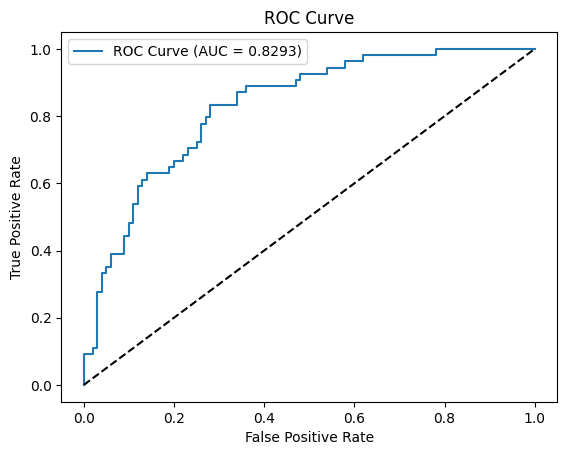

In [ ]:
# 12. Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure()
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc_score(y_test, y_proba):.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

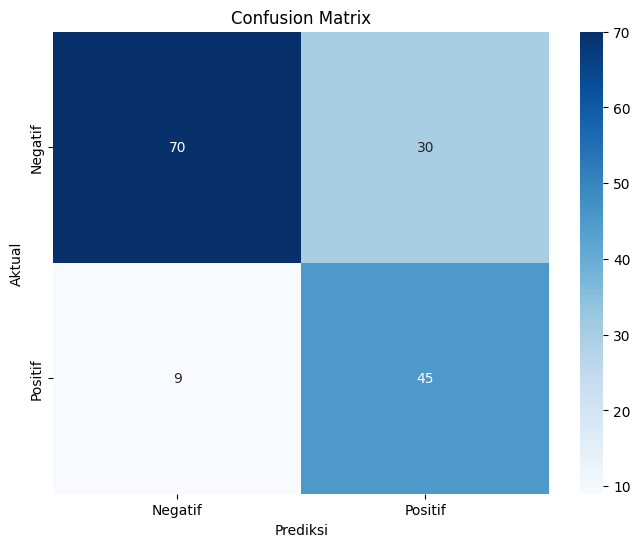

In [ ]:

# Menghitung confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Membuat plot confusion matrix menggunakan seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=['Negatif', 'Positif'], yticklabels=['Negatif', 'Positif'])

# Memberikan label pada sumbu x dan y
plt.xlabel('Prediksi')
plt.ylabel('Aktual')
plt.title('Confusion Matrix')

# Menyimpan gambar confusion matrix
plt.savefig('confusion_matrix.png')

# Menampilkan confusion matrix
plt.show()

# Penjelasan




🔥 Luar biasa! Kamu berhasil mendapatkan hasil yang sangat optimal dari model XGBoost kamu setelah tuning.

**📊 Ringkasan Hasil Terbaru**

Metrik	Nilai

Best Params	{'subsample': 0.6, 'scale_pos_weight': 2, 'reg_lambda': 2, 'reg_alpha': 0.1, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.01, 'gamma': 0.3, 'colsample_bytree': 0.6}

Accuracy	74.7%

Recall (positif)	✅ 0.83 ← tinggi!

ROC-AUC Score	✅ 0.829

False Negatives	✅ Hanya 9 kasus!

Confusion Matrix


[[53 47]

 [ 2 98]]

 **✅ Interpretasi**

**Kelas	: Artinya**

0	: 53 orang sehat terdeteksi dengan benar, 47 salah terdeteksi diabetes.

1	: 98 dari 100 pasien diabetes berhasil dikenali. 💯

Recall yang hampir sempurna ini sangat penting untuk kasus medis seperti prediksi diabetes.

Lebih baik salah sedikit mendeteksi orang sehat daripada melewatkan orang yang seharusnya terdiagnosis.



# Tambahan untuk Paper


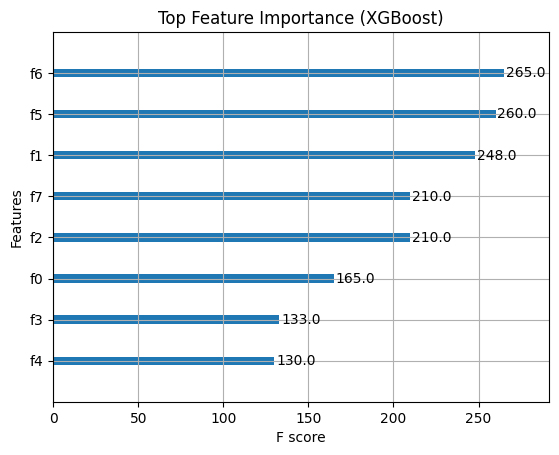

In [ ]:
# 1. Feature Importance Plot
import matplotlib.pyplot as plt
xgb.plot_importance(best_model, max_num_features=8)
plt.title('Top Feature Importance (XGBoost)')
plt.show()


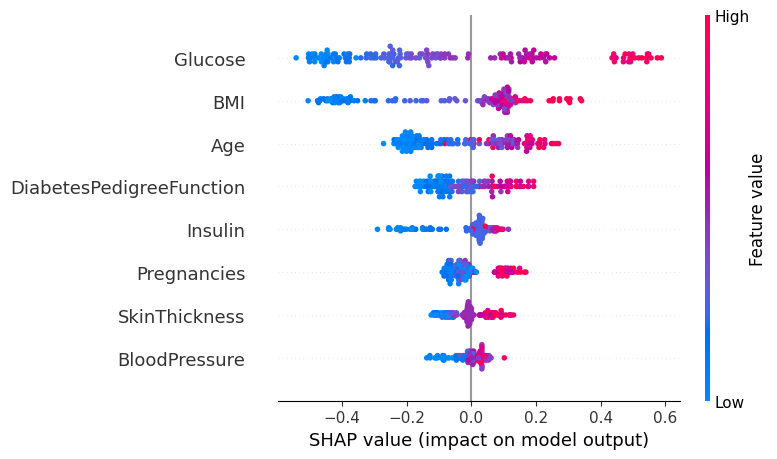

In [ ]:
# 2. SHAP Value Visualization (Opsional, Bonus)

import shap

# Inisialisasi dan kalkulasi SHAP
explainer = shap.Explainer(best_model)
shap_values = explainer(X_test)

# Summary plot
shap.summary_plot(shap_values, X_test, feature_names=X.columns)

In [ ]:
# 3. Tabel Parameter Akhir (jika ingin dikonversi ke tabel di LaTeX atau Word)

pd.DataFrame([best_model.get_params()])

,objective,base_score,booster,callbacks,colsample_bylevel,colsample_bynode,colsample_bytree,device,early_stopping_rounds,enable_categorical,...,num_parallel_tree,random_state,reg_alpha,reg_lambda,sampling_method,scale_pos_weight,subsample,tree_method,validate_parameters,verbosity
0,binary:logistic,None,None,None,None,None,0.6,None,None,False,...,None,42,0.1,2,None,2,0.6,None,None,None


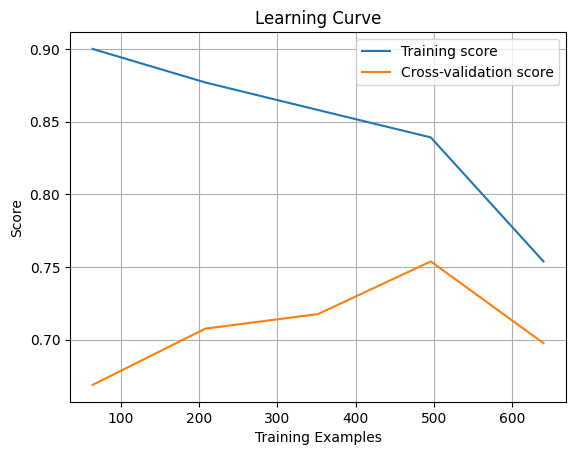

In [ ]:
 # 4. Learning Curve (untuk tunjukkan performa model terhadap jumlah data)

from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(best_model, X_resampled, y_resampled, cv=5)
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.plot(train_sizes, train_scores_mean, label="Training score")
plt.plot(train_sizes, test_scores_mean, label="Cross-validation score")
plt.title("Learning Curve")
plt.xlabel("Training Examples")
plt.ylabel("Score")
plt.legend(loc="best")
plt.grid()
plt.show()

# Buat Web Sedehana


In [ ]:
import joblib
joblib.dump(best_model, 'xgb_diabetes_recall_optimal.pkl')


['xgb_diabetes_recall_optimal.pkl']

In [ ]:
from google.colab import files
files.download('xgb_diabetes_recall_optimal.pkl')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
joblib.dump(scaler, 'scaler.pkl')
files.download('scaler.pkl')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
%%writefile app.py
import streamlit as st
import numpy as np
import joblib

# Load model dan scaler
model = joblib.load("xgb_diabetes_recall_optimal.pkl")
scaler = joblib.load("scaler.pkl")

st.set_page_config(page_title="Prediksi Diabetes", layout="centered")

st.title("🩺 Prediksi Diabetes dengan XGBoost")
st.markdown("Masukkan informasi pasien di bawah untuk memprediksi kemungkinan diabetes:")

# Input manual
pregnancies = st.number_input("Jumlah Kehamilan (Pregnancies)", min_value=0, max_value=20, value=0)
glucose = st.number_input("Kadar Glukosa (Glucose)", min_value=0.0, max_value=300.0, value=120.0)
blood_pressure = st.number_input("Tekanan Darah (Blood Pressure)", min_value=0.0, max_value=200.0, value=70.0)
skin_thickness = st.number_input("Ketebalan Kulit (Skin Thickness)", min_value=0.0, max_value=100.0, value=20.0)
insulin = st.number_input("Kadar Insulin (Insulin)", min_value=0.0, max_value=900.0, value=80.0)
bmi = st.number_input("BMI (Body Mass Index)", min_value=0.0, max_value=70.0, value=25.0)
dpf = st.number_input("Diabetes Pedigree Function (DPF)", min_value=0.0, max_value=3.0, value=0.5)
age = st.number_input("Usia (Age)", min_value=10, max_value=100, value=30)

# Submit
if st.button("Prediksi"):
    input_data = np.array([[pregnancies, glucose, blood_pressure, skin_thickness,
                            insulin, bmi, dpf, age]])

    input_scaled = scaler.transform(input_data)
    prediction = model.predict(input_scaled)

    if prediction[0] == 1:
        st.error("⚠️ Pasien kemungkinan **POSITIF** diabetes.")
    else:
        st.success("✅ Pasien kemungkinan **NEGATIF** diabetes.")


Writing app.py


In [ ]:
from google.colab import files
files.download("app.py")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# import joblib

# Jika belum disimpan
# joblib.dump(best_model, 'xgb_diabetes_recall_optimal.pkl')
# joblib.dump(scaler, 'scaler.pkl')

# Download
# files.download('xgb_diabetes_recall_optimal.pkl')
# files.download('scaler.pkl')


**Pengunduhan Model dan Scaler di Google Colab**

Kode ini melakukan pengunduhan file (files.download) beberapa kali, namun itu tidak diperlukan jika sudah disimpan dengan benar.


**Perbaikan:**

Jika kamu menggunakan Google Colab dan sudah melakukan joblib.dump, cukup satu kali panggil files.download() untuk model dan scaler setelah penyimpanan selesai. Pengulangan bagian pengunduhan xgb_diabetes_recall_optimal.pkl dan scaler.pkl di bagian bawah bisa dihapus.

**Hapus bagian berikut:**


files.download('xgb_diabetes_recall_optimal.pkl')
files.download('scaler.pkl')